In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as stats

In [16]:
# load train data
train = pd.read_csv('microarray_train.csv', index_col=0)

# save indexes of ALL and AML samples
allidx = train[train['cancer']=='ALL'].index
#print(allidx)
amlidx = train[train['cancer']=='AML'].index
#print(amlidx)

# seprate target from features
target = train.pop('cancer')
print(train.shape)
train.head()

(38, 7129)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [17]:
# label encode target, ALL:0, AML:1
le = LabelEncoder()
target = le.fit_transform(target)
print(le.classes_)
target

['ALL' 'AML']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

(array([7.064e+03, 4.500e+01, 1.200e+01, 4.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.76901849e+02, 1.60932810e+07, 3.21860850e+07, 4.82788891e+07,
        6.43716931e+07, 8.04644972e+07, 9.65573013e+07, 1.12650105e+08,
        1.28742909e+08, 1.44835713e+08, 1.60928518e+08]),
 <BarContainer object of 10 artists>)

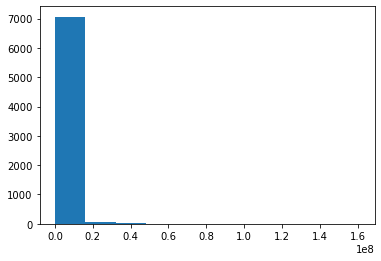

In [18]:
# create dataframe of metrics
metrics = pd.DataFrame()
# compute variances of each feature
metrics['variance'] = train.var()
plt.hist(x=metrics['variance'])

In [19]:
# compute percent positive intensity values for each feature
metrics['pctvalpos'] = [sum(train[col]>0)/len(train[col]) for col in train.columns]
metrics.describe()

,variance,pctvalpos
count,7.129000e+03,7129.000000
mean,6.820928e+05,0.712394
std,3.845060e+06,0.354564
min,4.769018e+02,0.000000
25%,8.210373e+03,0.447368
50%,3.170128e+04,0.921053
75%,1.295735e+05,1.000000
max,1.609285e+08,1.000000


In [20]:
metrics[metrics['pctvalpos']>0.5].describe()

,variance,pctvalpos
count,5.163000e+03,5163.000000
mean,8.822834e+05,0.913275
std,4.357697e+06,0.129808
min,5.491074e+02,0.526316
25%,1.066643e+04,0.868421
50%,4.043881e+04,0.973684
75%,1.835392e+05,1.000000
max,1.609285e+08,1.000000


In [21]:
# compute mutual information scores
metrics['mi'] = mutual_info_classif(train, target, random_state=123)

In [22]:
# compute regular p-values for each feature between ALL and AML 
pval=[]
for col in range(len(train.columns)):
    pval.append(stats.ttest_ind(train.iloc[amlidx,col], train.iloc[allidx,col], equal_var=False)[1]) # store p-val
metrics['pval'] = pval    

# compute p-values with stats for each feature between ALL and AML 
#pval2 = []
#for col in range(len(train.columns)):
#    m1 = train.iloc[allidx,col].mean()
#    sd1 = np.std(train.iloc[allidx,col])
#    m2 = train.iloc[amlidx,col].mean()
#    sd2 = np.std(train.iloc[amlidx,col])
#    pval2.append(stats.ttest_ind_from_stats(mean1=m1, std1=sd1, nobs1=len(allidx),\
#                                            mean2=m2, std2=sd2, nobs2=len(amlidx), equal_var=False)[1])
#metrics['pval2'] = pval2


In [23]:
# compute adjusted p-values for each feature between ALL and AML with permutations 
pval=[]
for col in range(len(train.columns)):
    pval.append(stats.ttest_ind(train.iloc[amlidx,col], train.iloc[allidx,col], \
                                permutations=1500, random_state=123,equal_var=False)[1]) # store p-val
metrics['adj_pval'] = pval    


In [24]:
metrics.describe()

,variance,pctvalpos,mi,pval,adj_pval
count,7.129000e+03,7129.000000,7129.000000,7.129000e+03,7129.000000
mean,6.820928e+05,0.712394,0.053071,3.426886e-01,0.347394
std,3.845060e+06,0.354564,0.071800,3.082058e-01,0.311346
min,4.769018e+02,0.000000,0.000000,8.388715e-09,0.000000
25%,8.210373e+03,0.447368,0.000000,5.578156e-02,0.055333
50%,3.170128e+04,0.921053,0.021545,2.591065e-01,0.266000
75%,1.295735e+05,1.000000,0.085021,5.888123e-01,0.604000
max,1.609285e+08,1.000000,0.537751,9.996315e-01,1.000000


In [25]:
metrics

,variance,pctvalpos,mi,pval,adj_pval
AFFX-BioB-5_at,12002.441679,0.105263,0.088318,0.185434,0.199333
AFFX-BioB-M_at,5735.715505,0.000000,0.000000,0.334354,0.318000
AFFX-BioB-3_at,13850.028450,0.342105,0.000000,0.818418,0.800000
AFFX-BioC-5_at,13798.731863,0.921053,0.158517,0.002964,0.008000
AFFX-BioC-3_at,12321.983642,0.000000,0.051573,0.942938,0.940667
...,...,...,...,...,...
X83863_at,232677.402560,1.000000,0.000000,0.094710,0.090000
Z17240_at,44027.271693,1.000000,0.000000,0.818077,0.826000
L49218_f_at,970.873400,0.789474,0.084441,0.110234,0.113333
M71243_f_at,531068.407539,0.973684,0.166143,0.022379,0.011333


<AxesSubplot:xlabel='adj_pval', ylabel='Count'>

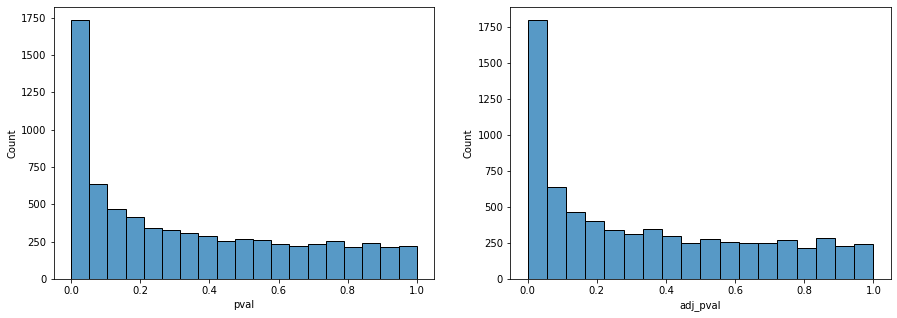

In [26]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(x='pval', data=metrics, ax=axs[0])
sns.histplot(x='adj_pval', data=metrics, ax=axs[1])

In [27]:
metrics[metrics['adj_pval']<=0.001].describe()

,variance,pctvalpos,mi,pval,adj_pval
count,3.590000e+02,359.000000,359.000000,3.590000e+02,359.000000
mean,1.680182e+06,0.852514,0.216149,1.923520e-03,0.000206
std,4.639944e+06,0.243471,0.090169,6.073429e-03,0.000309
min,1.067118e+03,0.000000,0.009731,8.388715e-09,0.000000
25%,3.729134e+04,0.815789,0.155469,8.184466e-05,0.000000
50%,1.380866e+05,0.973684,0.208521,3.137920e-04,0.000000
75%,7.278592e+05,1.000000,0.273472,1.362985e-03,0.000667
max,3.635688e+07,1.000000,0.537751,6.124505e-02,0.000667


In [28]:
metrics[metrics['adj_pval']<=0.001].index

Index(['AB000449_at', 'AF000231_at', 'AF005043_at', 'AF009426_at',
       'AF015950_at', 'D00763_at', 'D10495_at', 'D13627_at', 'D14658_at',
       'D14874_at',
       ...
       'M19888_at', 'M31523_at', 'U27460_at', 'U84388_at', 'X16546_at',
       'Z30644_at', 'M28170_at', 'U20499_at', 'X07730_at', 'U29175_at'],
      dtype='object', length=359)

In [29]:
metrics[metrics['mi']>=0.15].describe()

,variance,pctvalpos,mi,pval,adj_pval
count,7.560000e+02,756.000000,756.000000,7.560000e+02,756.000000
mean,1.333627e+06,0.774158,0.215246,9.935494e-02,0.099489
std,4.690694e+06,0.322139,0.063126,2.099723e-01,0.215004
min,1.007588e+03,0.000000,0.150135,8.388715e-09,0.000000
25%,2.494368e+04,0.657895,0.168330,5.552715e-04,0.000000
50%,8.583665e+04,0.947368,0.193948,6.751089e-03,0.004667
75%,4.386313e+05,1.000000,0.242216,5.547621e-02,0.052333
max,6.425958e+07,1.000000,0.537751,9.816323e-01,0.986667


In [30]:
metrics[metrics['mi']>=0.15].index

Index(['AFFX-BioC-5_at', 'AFFX-PheX-M_at', 'AFFX-HUMRGE/M10098_5_at',
       'AFFX-HUMRGE/M10098_3_at', 'AFFX-HUMTFRR/M11507_5_at',
       'AFFX-HUMTFRR/M11507_M_at', 'AFFX-HUMTFRR/M11507_3_at',
       'AC002115_cds4_at', 'AC002464_at', 'AF000231_at',
       ...
       'U20499_at', 'U21689_at', 'Z68193_at', 'M27749_r_at', 'D38437_f_at',
       'J00117_f_at', 'V01516_f_at', 'L10717_at', 'U29175_at', 'M71243_f_at'],
      dtype='object', length=756)

<AxesSubplot:>

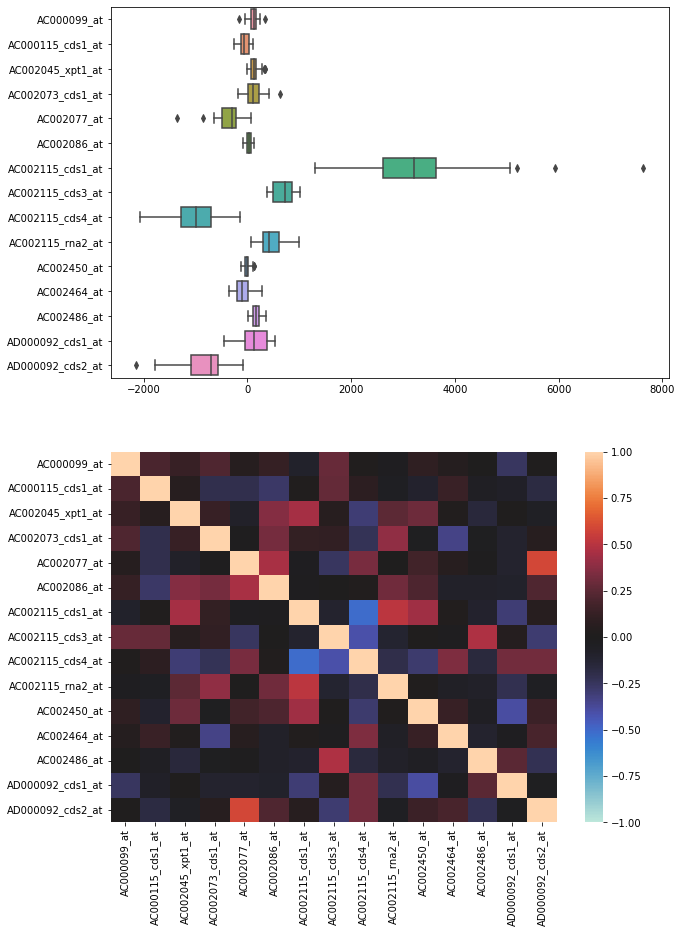

In [31]:
# quick look at 15 features
fig, ax = plt.subplots(2,1,figsize=(10,15))
sns.boxplot(data=train[train.columns[100:115]], orient='h', ax=ax[0])
corrmat = train[train.columns[100:115]].corr()
sns.heatmap(corrmat, vmin=-1,vmax=1, center=0, ax=ax[1])

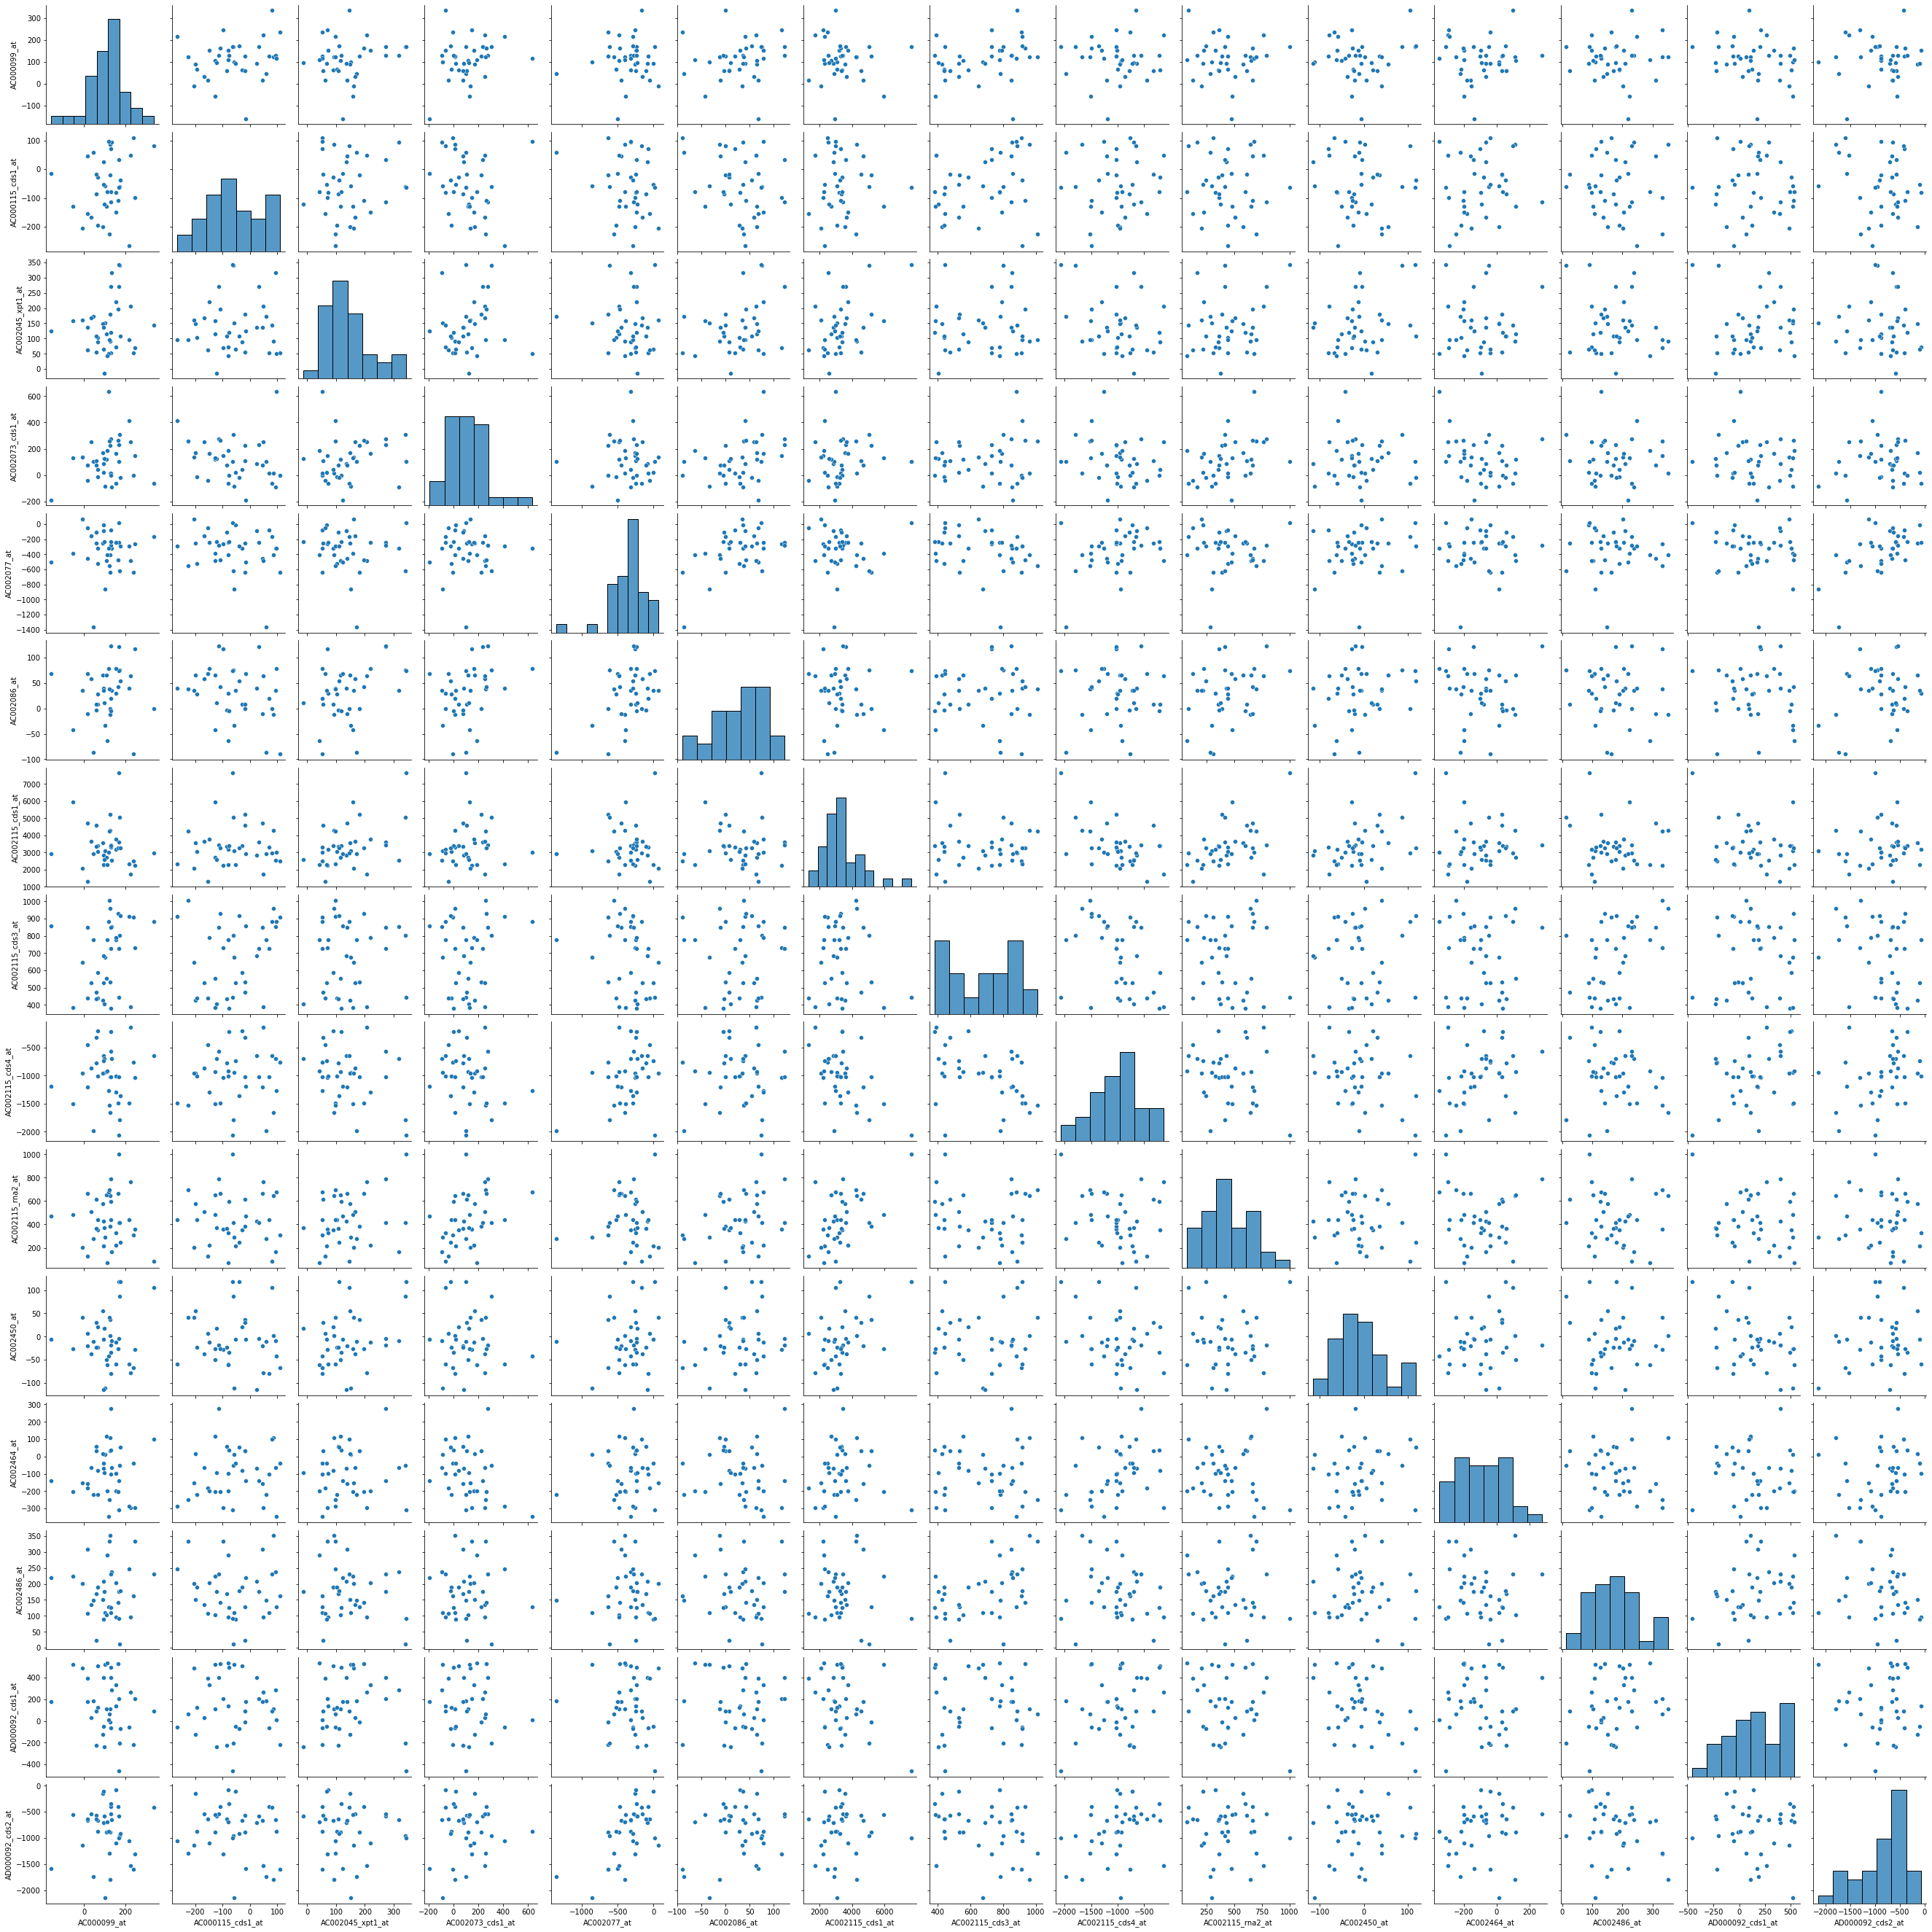

In [32]:
sns.pairplot(data=train[train.columns[100:115]])